In [37]:
import pandas as pd
import numpy as np

#This is the UK land registry house prices paid dataset from kaggle
#https://www.kaggle.com/hm-land-registry/uk-housing-prices-paid
#it has been converted int a .db file
from sqlalchemy import create_engine
csv_database = create_engine('sqlite:///csv_database.db')

#This is a dictionary of geolocations for various uk towns and cities, it was taken from geonames.org and has been  
#parsed into a dictionary then pickled (dee cities_geo.ipnb) 
#The dictionary was then manually edited so that the city names in the house sales dataset fit 
#see geomismatchremover.ipynb
#eg: hull<-> kingston upon hull
#eg henley upon thames <-> henley on thames etc. etc. this was done manually
import pickle
cleangeolocations = pickle.load( open( "citiesnopunc.pkl", "rb" ) )

In [38]:
import string as stringlib

#This queries the sql file and returns a data frame with sales in the spacified month and year along with price
def dfgen(month,year):
    sqlstring='SELECT [Town/City], District, Price, strftime("%Y",DateofTransfer)as Year, strftime("%m",DateofTransfer)as Month FROM "table"  WHERE Cast(Year as int)== ? AND Cast(Month as int)== ?' 
    return pd.read_sql_query(sqlstring, csv_database,params={str(year),str(month)})



    
#This takes a string and returns the string with non alphanumeric charachters removed and capitalised   
def clean_string(string):
 for char in stringlib.punctuation:
     string = string.replace(char,'').replace(' ', '')
 return string.upper()


In [39]:

#rows whose city entry is london need to be divided up between their various districts
def cleangeolocationslsp(city,district):
    if city != 'LONDON':
        return cleangeolocations.get(city)
    else:
        return cleangeolocations.get(district)

In [40]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors

#Input a dataframe of format: Town/City	Price	Year	Month	
def plotgen(df):
    
    #These two variables are the Town/City and district columns stripped of their punctuation, whitespace
    #and capitalised
    cit=df.loc[:,"Town/City"].apply(clean_string).values
    dist=df.loc[:,"District"].apply(clean_string).values


    cleanplotdata=list(map(cleangeolocationslsp,cit,dist))
    
    #any antries where a city has failed to match to a geolocation are discarded below 
    cleanfplotdata=list(filter(lambda x:type(x)==tuple,cleanplotdata))
    
    #we also need to discard the whole row for entirs where the geolocation has failed so that the price 
    #color plot list is the same length as the list of coordiantes to be plotted andthey correstpond to the same sale 
    geofailindices=(np.where(pd.isnull(cleanplotdata))[0]).tolist()
    print(df.iloc[geofailindices])
    df=df.drop(df.index[geofailindices])
    
    #this puts the date into a filename friendly string  
    mydate=df.iloc[0,4] +'-'+ df.iloc[0,3] 
    filepath='plots/'+mydate+'.png'
    
    #gives info on any failed geolocations
    print(mydate+' '+str(len(cleanplotdata))+' entries ' +str(len(cleanfplotdata)-len(cleanplotdata)) +' failed geolocations')
    
    #the x and y coordiantes to be plotted
    y=[cpd[0] for cpd in cleanfplotdata]
    x=[cpd[1] for cpd in cleanfplotdata]
    
    #here we make use of cartopy
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='k',
                                        facecolor=cfeature.COLORS['land'])
    #the color map we wish to apply to our points
    cmap = plt.cm.jet
    #we use a logarithmic scale for the color map and set the max and min after some trial end error
    norm = matplotlib.colors.LogNorm(vmin=50000,vmax=740000)

    
    #here we plot our figure, notice the projection from coordiates on the earth to those on a map of the uk
    fig = plt.figure(figsize=(10,20))
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    plt.figure(figsize=(12,6))

    ax.set_extent([ -7.781181, 2.514105,48.467529, 57.805202,])
    ax.add_feature(land_50m)
    ax.scatter(x,y,color=cmap(norm(df.Price.values)),s=1.5, zorder=10)
    ax.text( 0.3,57, mydate, fontsize=15)
    
    fig.savefig(filepath)
    plt.show()
    return ax

Empty DataFrame
Columns: [Town/City, District, Price, Year, Month]
Index: []
02-1997 70350 entries 0 failed geolocations


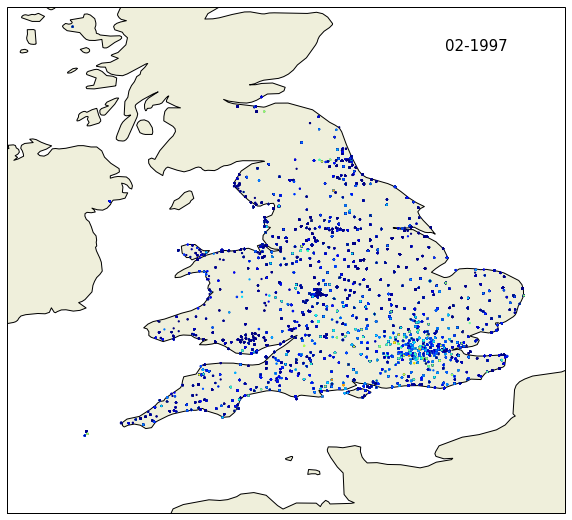

<Figure size 864x432 with 0 Axes>

In [41]:
plotgen(dfgen(2,1997))

In [1]:
#just a loop to get all of the months in the database and produce plots
for i in range(1995,2018):
    for j in range(1,13):
        plotgen(dfgen(j,i))
#02-2004 problem

In [56]:
import cv2

#this creates a video from the images
months=["%02d" % x for x in range(1,13)]
img=[]
for i in range(1995,2018):
    for j in months:
        if os.path.isfile('plots/'+str(j)+'-'+str(i)+'.png')==True:
            img.append(cv2.imread('plots/'+str(j)+'-'+str(i)+'.png'))



    
height , width , layers =  img[0].shape

video = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*"MJPG"),3,(width,height))

for x in img:
    #print(type(x))
    video.write(x)

cv2.destroyAllWindows()
video.release()

False
